In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio import plot
import rasterio
from shapely import geometry
import visualization
from syspy.skims import skims
from quetzal.io import excel

SQLalchemy is not installed. No support for SQL output.


In [3]:
sm = stepmodel.read_zippedpickles(r'../../model/{scen}/assignment'.format(scen=scenario))
raster = rasterio.open(r'../../inputs/tiff/20137.tiff', )

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.32it/s]


In [4]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

# INFRASTRUCTURES

In [5]:
sm.links.columns

Index(['a', 'b', 'link_sequence', 'direction_id', 'line', 'trip_id',
       'route_id', 'road_a', 'road_b', 'road_node_list', 'road_link_list',
       'road_length', 'geometry', 'route_type', 'mode', 'headway',
       'vehicle_capacity', 'per_hour', 'capacity', 'length', 'time', 'pt',
       'boardings', 'alightings'],
      dtype='object')

In [6]:
sm.links['route_type']

link_0       bajaj
link_1       bajaj
link_2       bajaj
link_3       bajaj
link_4       bajaj
             ...  
link_1523    bajaj
link_1524    bajaj
link_1525    bajaj
link_1526    bajaj
link_1527    bajaj
Name: route_type, Length: 1528, dtype: object

In [7]:
try:
    sm.links['mode'] = sm.links['mode_' + var['general']['routes_code']] #verify
except KeyError:
    sm.links['mode'] = sm.links['route_type']

from syspy.assignment.raw import fast_assign as assign
rl = sm.road_links[['length']]
modes = list(set(sm.links['mode']))

for mode in modes:
    l = sm.links.loc[sm.links['mode'] == mode].copy()
    l['dummy'] = 1 
    rl[mode] = np.clip(assign(l['dummy'], l['road_link_list']), 0, 1)
    rl[mode] = rl[mode] * rl['length']
    
routes = list(set(sm.links['route_id']))
for route in routes:
    l = sm.links.loc[sm.links['route_id'] == route].copy()
    l['dummy'] = 1 
    rl[route] = np.clip(assign(l['dummy'], l['road_link_list']), 0, 1)
    rl[route] = rl[route] * rl['length']
    
route_sum = rl[routes].sum()
mode_sum = rl[modes].sum()

# stacks

In [8]:
model_to_day = var['post_parameters']['model_to_day']
model_duration = var['post_parameters']['model_duration'] # hour
vehicle_disponibility = var['post_parameters']['vehicle_disponibility']
mobility_rate = var['post_parameters']['mobility_rate']

In [9]:
#headways = var['headway'].to_dict()

vehicle_capacities = var['vehicle_capacities'].to_dict()

#sm.links['headway'] = sm.links['mode'].apply(headways.get)
sm.links['per_hour'] = 3600 / sm.links['headway'] 
sm.links['vehicle_capacity'] = sm.links['mode'].apply(vehicle_capacities.get)
sm.links['capacity'] = (sm.links['vehicle_capacity'] * sm.links['per_hour']).astype(int)

# LINES

In [10]:
sm.links

a              b  link_sequence  direction_id   line  \
link_0        university  eshet grocery              0             0      0   
link_1     eshet grocery          seido              1             0      0   
link_2             seido  eshet grocery              0             0  0_bis   
link_3     eshet grocery     university              1             0  0_bis   
link_4        university  eshet grocery              0             0      1   
...                  ...            ...            ...           ...    ...   
link_1523    sabian agip         bridge              2             0  9_bis   
link_1524         bridge           dipo              3             0  9_bis   
link_1525           dipo   sholla hotel              4             0  9_bis   
link_1526   sholla hotel       karamara              5             0  9_bis   
link_1527       karamara          shell              6             0  9_bis   

          trip_id route_id          road_a          road_b  \
link_0          0        0   road_node_797  road_node_1842   
link_1          0        0  road_node_1842  road_node_1667   
link_2      0_bis    0_bis  road_node_1667  road_node_1842   
link_3      0_bis    0_bis  road_node_1842   road_node_797   
link_4          1        1   road_node_797  road_node_1842   
...           ...      ...             ...             ...   
link_1523   9_bis    9_bis   road_node_822  road_node_4673   
link_1524   9_bis    9_bis  road_node_4673  road_node_2820   
link_1525   9_bis    9_bis  road_node_2820  road_node_1283   
link_1526   9_bis    9_bis  road_node_1283  road_node_2484   
link_1527   9_bis    9_bis  road_node_2484  road_node_2037   

                                              road_node_list  ...   mode  \
link_0     [road_node_797, road_node_1544, road_node_4944...  ...  bajaj   
link_1     [road_node_1842, road_node_1492, road_node_455...  ...  bajaj   
link_2     [road_node_1667, road_node_5020, road_node_219...  ...  bajaj   
link_3     [road_node_1842, road_node_3937, road_node_110...  ...  bajaj   
link_4     [road_node_797, road_node_1544, road_node_4944...  ...  bajaj   
...                                                      ...  ...    ...   
link_1523  [road_node_822, road_node_4075, road_node_4100...  ...  bajaj   
link_1524  [road_node_4673, road_node_2546, road_node_368...  ...  bajaj   
link_1525  [road_node_2820, road_node_2829, road_node_170...  ...  bajaj   
link_1526  [road_node_1283, road_node_1053, road_node_420...  ...  bajaj   
link_1527  [road_node_2484, road_node_5075, road_node_518...  ...  bajaj   

           headway vehicle_capacity per_hour capacity      length        time  \
link_0         180                5     20.0      100  881.078155  166.523771   
link_1         180                5     20.0      100  788.665218  149.057726   
link_2         180                5     20.0      100  788.665218  149.057726   
link_3         180                5     20.0      100  879.443209  166.214767   
link_4         180                5     20.0      100  881.078155  166.523771   
...            ...              ...      ...      ...         ...         ...   
link_1523      180                5     20.0      100  340.489477   64.352511   
link_1524      180                5     20.0      100  715.037442  135.142077   
link_1525      180                5     20.0      100  364.975454   68.980361   
link_1526      180                5     20.0      100  774.088746  146.302773   
link_1527      180                5     20.0      100  322.810487   61.011182   

                   pt   boardings  alightings  
link_0     136.005297  136.005297   23.586948  
link_1     146.531030   34.112680  146.531030  
link_2     145.108586  145.108586   79.356208  
link_3      72.254370    6.501992   72.254370  
link_4     454.866408  454.866408   23.586948  
...               ...         ...         ...  
link_1523   23.561646    1.598274         NaN  
link_1524   27.547545    3.985898    0.032780  
link_1525  

In [11]:
# simple example
sm.links['volume'] = sm.links['pt']
sm.links['vehicles'] = sm.links['time'] / sm.links['headway']
sm.links['km'] = sm.links['length'] / 1000

sm.links['vehicle_km'] = model_duration * sm.links['per_hour'] * sm.links['km'] 
sm.links['seat_km'] = model_duration * sm.links['per_hour'] * sm.links['km']* sm.links['capacity']
sm.links['voy_km'] = model_duration * sm.links['per_hour'] * sm.links['km']* sm.links['volume']
summary = sm.links.groupby(['route_id']).agg(
    {
        'boardings': 'sum', 
        'pt': 'max', 
        'vehicles': 'sum', 
        'length': 'sum', 
        'time': 'sum',
        'vehicle_km': 'sum',
        'seat_km': 'sum',
        'voy_km': 'sum',
        'headway': 'max',
        'capacity': 'max',
        'mode': 'first',
        
    }
)
sm.stack_routes = summary.stack()

In [12]:
sm.stack_routes.index.names = ['route_id', 'indicator']
sm.stack_routes.name = 'aggregated'

In [13]:
lines = summary.copy()
lines['design'] = lines['voy_km' ] / (lines['seat_km'] * (lines['pt'] / lines['capacity']))
lines['empty_seats'] = np.round(1 - lines['design'], 2)
lines['boardings'] = np.round(summary['boardings'] * model_to_day, -3).astype(int)
lines['vehicle_km'] = np.round(summary['vehicle_km'] * model_to_day, -2).astype(int)
lines['seat_km'] = np.round(summary['seat_km'] * model_to_day, -3).astype(int)
lines['voy_km'] = np.round(summary['voy_km'] * model_to_day, -3).astype(int)
lines['max_load'] = np.round(summary['pt'].fillna(0), -2).astype(int)
lines['vehicles'] = np.floor(lines['vehicles'] / vehicle_disponibility).astype(int) + 1
lines['minutes'] = np.round(lines['time'] / (2*60)).astype(int)

In [14]:
modes

['bajaj']

In [15]:
lines['km'] = np.round(route_sum/ (2*1000)).astype(int)
lines['saturation'] = np.round( lines['max_load'] / lines['capacity'], 1 )
try:
    lines.index = [int(i) for i in lines.index]
except ValueError: # base
    pass
lines.sort_index(inplace=True)
lines.index.name = 'line'
lines['voy_to_seat_km'] = lines['voy_km'] / lines['seat_km']
data = lines[
    [
        'mode', 'km', 'minutes',  'vehicles','vehicle_km', 
        'voy_km', 'seat_km', 'empty_seats',
        'headway', 'capacity',
        'max_load', 'saturation', 'boardings'
    ]
].set_index('mode', append=True).swaplevel().loc[modes]

total_boardings = data['boardings'].sum()

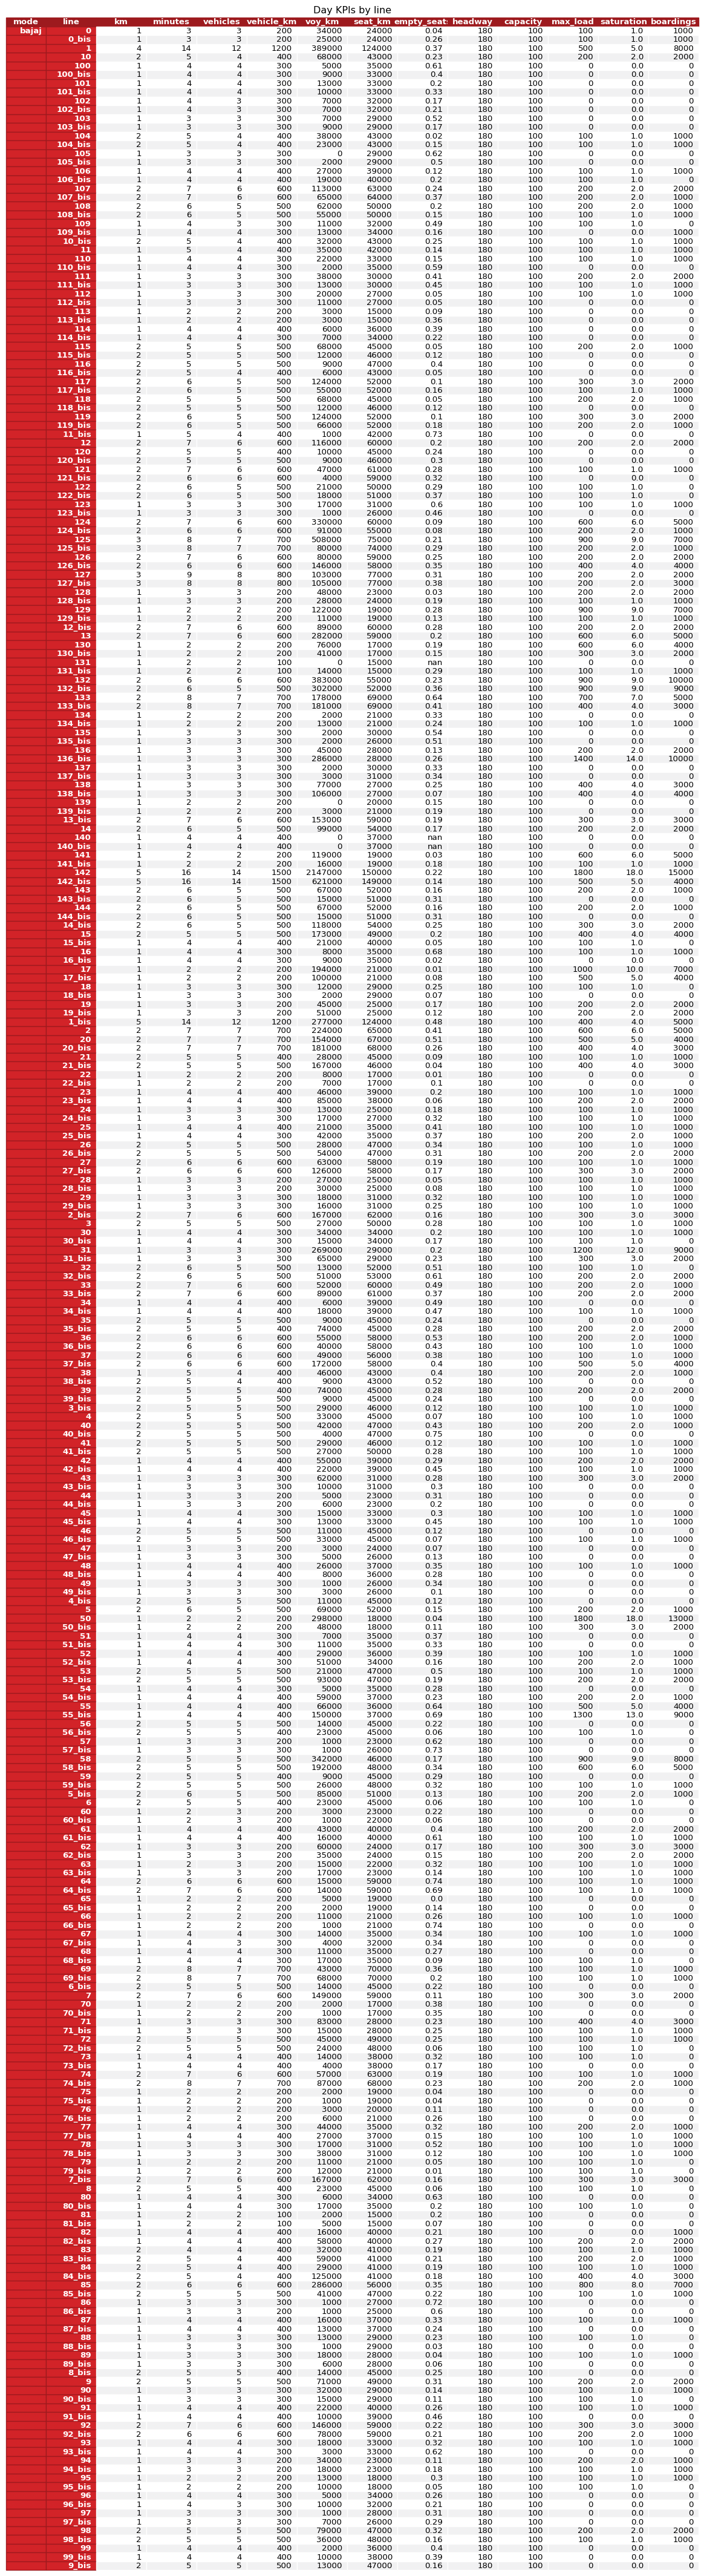

In [16]:
from imp import reload
reload(visualization)
plot = visualization.render_mpl_table(
    data.astype(str),
    header_size=10, font_size=10, #edge_color='darkgray',
    row_height=0.2, col_width=1.1, index_width_ratio=0.8,
)
plot.set_title('Day KPIs by line')
fig = plot.get_figure()
fig.savefig('../../outputs/lines_{scen}.png'.format(scen=scenario), bbox_inches='tight')

# saturation

In [17]:
sm.road_links['pt_capacity'] = assign(sm.links['capacity'], sm.links['road_link_list'])
sm.road_links['saturation'] = np.clip(sm.road_links['pt'] / sm.road_links['pt_capacity'], 0, 2)

In [18]:
# links
sm.links['volume'] = sm.links['pt']
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)

In [19]:
sm.road_links

highway  oneway  lanes                 name     type_ref  \
road_link_0      residential     0.0    1.0                 None  residential   
road_link_1      residential     0.0    2.0         Shinile Road  residential   
road_link_2      residential     0.0    2.0         Shinile Road  residential   
road_link_3      residential     0.0    1.0                 None  residential   
road_link_4          primary     1.0    2.0  Main East West Road      primary   
...                      ...     ...    ...                  ...          ...   
road_link_15420                  NaN    NaN                                     
road_link_15421         None     NaN    NaN                 None         None   
road_link_15422         None     NaN    NaN                 None  residential   
road_link_15423         None     NaN    NaN                 None  residential   
road_link_15424         None     NaN    NaN                 None  residential   

                   type_scat    type_poly    type_bipo               a  \
road_link_0      residential  residential  residential  road_node_1727   
road_link_1        secondary    secondary    secondary  road_node_1727   
road_link_2        secondary    secondary    secondary  road_node_1727   
road_link_3      residential  residential  residential  road_node_1457   
road_link_4          primary      primary      primary   road_node_529   
...                      ...          ...          ...             ...   
road_link_15420               residential               road_node_2249   
road_link_15421         None  residential         None  road_node_4532   
road_link_15422  residential  residential  residential  road_node_4898   
road_link_15423  residential  residential  residential  road_node_3650   
road_link_15424  residential  residential  residential  road_node_5320   

                              b  ... speed   walk_time       time  \
road_link_0      road_node_1153  ...  20.0   75.391506   9.423938   
road_link_1      road_node_1844  ...  20.0  123.381382  15.422673   
road_link_2      road_node_4960  ...  20.0  205.054336  25.631792   
road_link_3      road_node_1969  ...  20.0  219.398928  27.424866   
road_link_4      road_node_1667  ...  20.0  222.476638  27.809580   
...                         ...  ...   ...         ...        ...   
road_link_15420   road_node_958  ...  20.0  532.326464  66.540808   
road_link_15421  road_node_4638  ...  20.0  124.598620  15.574827   
road_link_15422  road_node_2887  ...  20.0   91.029590  11.378699   
road_link_15423  road_node_2887  ...  20.0  169.104446  21.138056   
road_link_15424  road_node_5047  ...  20.0   52.839615   6.604952   

                           index           pt         load        walk  \
road_link_0          road_link_0          NaN          NaN         NaN   
road_link_1          road_link_1   108.004528   108.004528         NaN   
road_link_2          road_link_2    19.567734    19.567734         NaN   
road_link_3          road_link_3          NaN          NaN    0.000000   
road_link_4          road_link_4  2564.400896  2564.400896  370.230138   
...                          ...          ...          ...         ...   
road_link_15420  road_link_15420          NaN          NaN    0.000000   
road_link_15421  road_link_15421          NaN          NaN         NaN   
road_link_15422  road_link_15422          NaN          NaN    3.070008   
road_link_15423  road_link_15423          NaN          NaN         NaN   
road_link_15424  road_link_15424          NaN          NaN         NaN   

                        car  pt_capacity saturation  
road_link_0             NaN          NaN        NaN  
road_link_1             NaN        100.0   1.080045  
road_link_2             NaN        100.0   0.195677  
road_link_3             NaN          NaN        NaN  
road_link_4      498.973642        300.0   2.000000  
...                     ...          ...        ...  
road_link_15420    0.000000          NaN        NaN  
road_link

## path sum

In [20]:
from syspy.skims import skims
euclidean = skims.euclidean(sm.zones.to_crs(epsg=4326)).set_index(['origin', 'destination'])
intrazonal = 0.8
euclidean['km'] = euclidean['euclidean_distance']/1000 + intrazonal

In [21]:
df = sm.los
df['length'] = 1000 #TODO : change that
df = pd.merge(df, euclidean[['km']].reset_index(), on=['origin', 'destination'])
df.loc[df['origin'] == df['destination'], 'time'] = 300 #TODO change intrazonal time
df['voy_hour'] = df['time'] * df['volume'] / 3600
df['voy_km'] = df['km'] * df['volume'] 
df['voy_price'] = df['price'] * df['volume']
stack = df.groupby('route_type')[['volume', 'voy_hour', 'voy_km', 'voy_price']].sum().stack()
stack.index.names = ['route_type', 'indicator']
stack.name = 'sum'
sm.stack_path_sum = stack

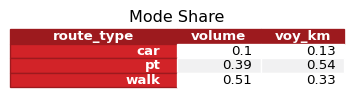

In [22]:
us = stack.unstack()
normalized = us.apply(lambda s: s / s.sum())
data = np.round(normalized[['volume', 'voy_km']], 2)#.plot(kind='pie', subplots=True)
data
sm.stack_shares = data.stack()
sm.stack_shares.name = 'share'
plot = visualization.render_mpl_table(
    data.astype(str),
    header_size=10, font_size=10, 
    row_height=0.2, col_width=1.5, index_width_ratio=2,
)
plot.set_title('Mode Share')
fig = plot.get_figure()
fig.savefig('../../outputs/mode_share_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [23]:
sm.links['boardings'].sum() / sm.los.groupby('route_type')['volume'].sum()['pt']

1.516712301417946

In [24]:
sm.stack_path_sum

route_type  indicator
car         volume         9817.799361
            voy_hour       2062.433866
            voy_km        33951.975955
            voy_price    294533.980826
pt          volume        37462.446700
            voy_hour      20901.942373
            voy_km       135355.072453
            voy_price    187312.233501
walk        volume        48821.284439
            voy_hour      15259.333855
            voy_km        82521.208554
            voy_price         0.000000
Name: sum, dtype: float64

In [25]:
aggregated = us.sum()

In [38]:
sm.volumes['todos'].sum()

96101.5305

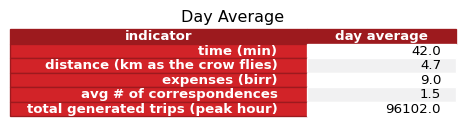

In [27]:
trip_average = aggregated[['voy_hour', 'voy_km', 'voy_price']].apply(lambda s: s/aggregated['volume'])
day_average = trip_average * mobility_rate
day = day_average[[]]
day['time (min)'] = int(day_average['voy_hour'] * 60)
day['distance (km as the crow flies)'] = np.round(day_average['voy_km'], 1)
day['expenses (birr)'] = np.round(day_average['voy_price'], 1)
day['avg # of correspondences'] = np.round(summary['boardings'].sum()/sm.stack_path_sum['pt']['volume'],1)
day['total generated trips'] = np.round(sm.volumes['todos'].sum()) * model_to_day
data = day
sm.stack_day = day
day.index.name = 'indicator'
day.name = 'day average'
plot = visualization.render_mpl_table(
    pd.DataFrame(day.astype(str)),
    header_size=10, font_size=10, 
    row_height=0.2, col_width=3, index_width_ratio=2,
)
plot.set_title('Day Average')
fig = plot.get_figure()
fig.savefig('../../outputs/day_average_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [28]:
average = stack.unstack().sum()
average = average / average['volume']
sm.stack_path_average = average.rename({'voy_hour': 'hour', 'voy_km': 'km', 'voy_price': 'price'})
sm.stack_path_average.name = 'average'

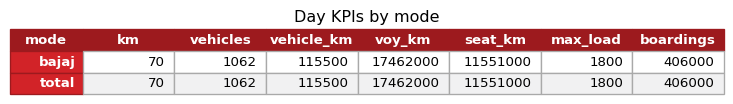

In [29]:
summary = sm.links.groupby(['mode']).agg(
    {
        'boardings': 'sum', 
        'pt': 'max', 
        'vehicles': 'sum', 
        'length': 'sum', 
        'time': 'sum',
        'vehicle_km': 'sum',
        'seat_km': 'sum',
        'voy_km': 'sum',
        'headway': 'max',
        'capacity': 'max',
        'mode': 'first',
        
    }
)
modes = summary.copy()
modes['design'] = modes['voy_km' ] / (modes['seat_km'] * (modes['pt'] / modes['capacity']))
modes['boardings'] = np.round(summary['boardings'] * model_to_day, -3).astype(int)
modes['vehicle_km'] = np.round(summary['vehicle_km'] * model_to_day, -2).astype(int)
modes['seat_km'] = np.round(summary['seat_km'] * model_to_day, -3).astype(int)
modes['voy_km'] = np.round(summary['voy_km'] * model_to_day, -3).astype(int)
modes['max_load'] = np.round(summary['pt'], -2).astype(int)
modes['vehicles'] = np.floor(modes['vehicles'] / vehicle_disponibility).astype(int) + 1

modes['km'] = np.round(mode_sum/ (2*1000)).astype(int)
modes['saturation'] = np.round( modes['max_load'] / modes['capacity'], 1 )
modes['voy_to_seat_km'] = modes['voy_km'] / modes['seat_km']
modes = modes[
    [
        'km', 'vehicles','vehicle_km', 
        'voy_km', 'seat_km', 
        'max_load', 'boardings'
    ]
]
modes.loc['total'] = modes.agg(
    {'km': sum,
     'vehicles':sum,
     'vehicle_km':sum,
    'voy_km':sum,
     'seat_km':sum,
     'boardings':sum,
     'max_load':max,
    }
)

data = modes
plot = visualization.render_mpl_table(
    data.astype(str),
    header_size=10, font_size=10, 
    row_height=0.3, col_width=1.2, index_width_ratio=0.8,edge_color='darkgrey'
)
plot.set_title('Day KPIs by mode')
fig = plot.get_figure()
fig.savefig('../../outputs/modes_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [30]:
modes.columns.name = 'indicator'
mode
sm.stack_modes = modes.stack()

In [31]:
sm.stack_modes.name = 'aggregated'

In [32]:
# all attrs from sm starting with 'stack' will be dumped to the filepath a an unique excel file
sm.to_excel(filepath='../../model/{scen}/summaries.xlsx'.format(scen=scenario), prefix='stack')

# maps

In [33]:
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt

from syspy.syspy_utils.data_visualization import base_plot, width_series, linewidth_from_data_units
from syspy.syspy_utils.data_visualization import geometry
def bandwidth(
    gdf, value_column, max_value=None, power=1, legend=True, legend_values=None, legend_length=1 / 3,
    label_column=None, max_linewidth_meters=100, variable_width=True, line_offset=True, cmap='Spectral',
    geographical_bounds=None, label_kwargs={'size': 12}, vmin=None, vmax=None, *args, **kwargs
):
    # TODO:
    # 1. add to plot model
    # 2. add arrows?

    # Can only plot valid LineString
    df = gdf[gdf.length > 0].sort_values(value_column).copy()
    df = df[df.geometry.type == 'LineString']


    plot = base_plot(df, geographical_bounds, *args, **kwargs)

    divider = make_axes_locatable(plot)
    cax = divider.append_axes('right', size="2%", pad=0.05)
    
    # Plot values
    # Power scale
    df['power'] = np.power(df[value_column], power)
    power_max_value = np.power(max_value, power) if max_value else df['power'].max()
    # Linewidth
    df['geographical_width'] = width_series(df['power'], max_linewidth_meters, max_value=power_max_value)
    df['linewidth'] = linewidth_from_data_units(df['geographical_width'].values, plot)
    # Offset
    if line_offset:
        df['geometry'] = df.apply(
            lambda x: x['geometry'].parallel_offset(x['geographical_width'] * 0.5, 'right'), 1
        )
        df = df[df.geometry.type == 'LineString']
        df = df[df.length > 0]  # offset can create empty LineString
        # For some reason, right offset reverse the coordinates sequence
        # https://github.com/Toblerity/Shapely/issues/284
        df['geometry'] = df.geometry.apply(lambda x: geometry.LineString(x.coords[::-1]))
    # Plot
    #return df
    df.plot(
        column=value_column, linewidth=df['linewidth'], ax=plot, legend=True, 
        vmin=vmin, vmax=vmax, cax=cax, cmap=cmap)
    plot.set_yticks([])
    plot.set_xticks([])
    return plot

# ASSIGNMENT PLOTS

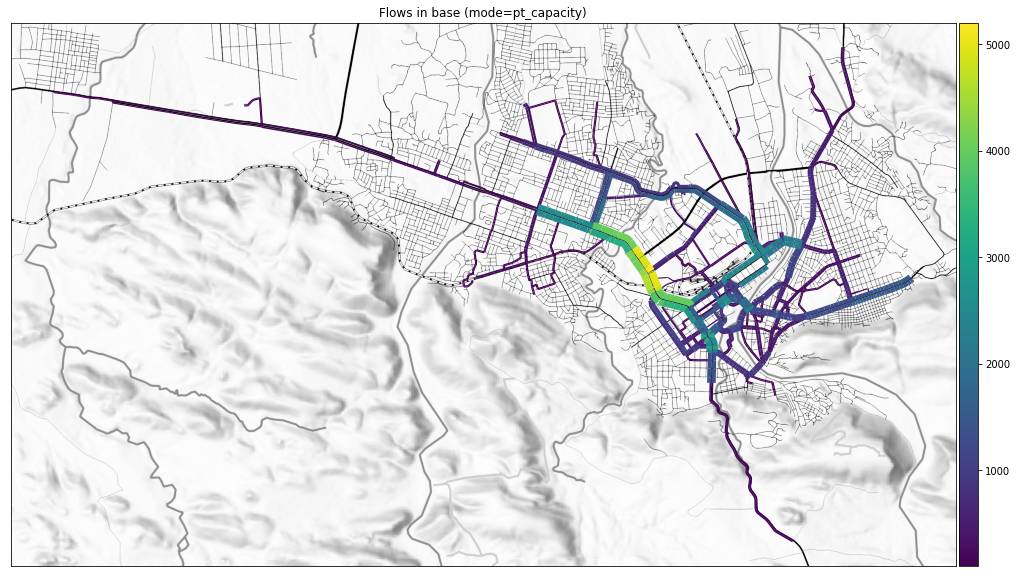

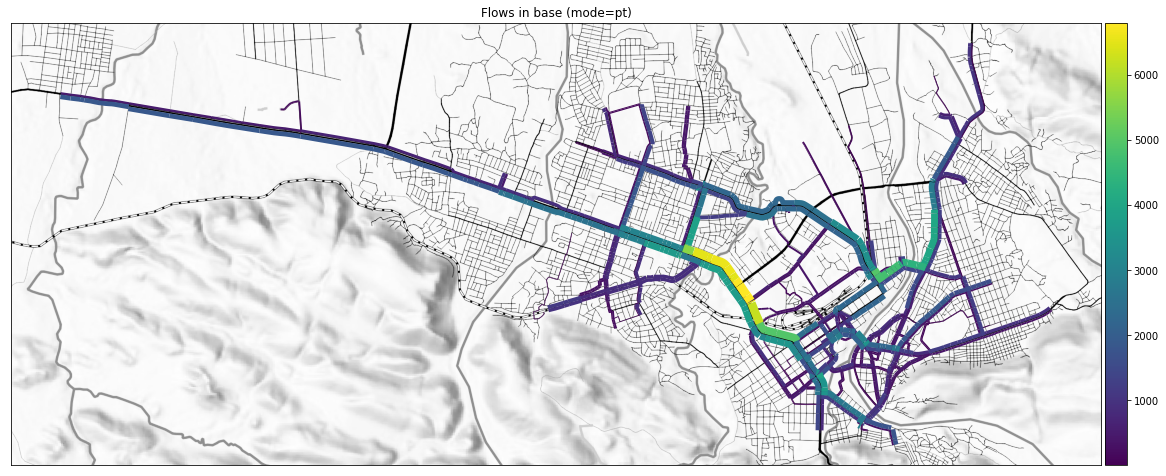

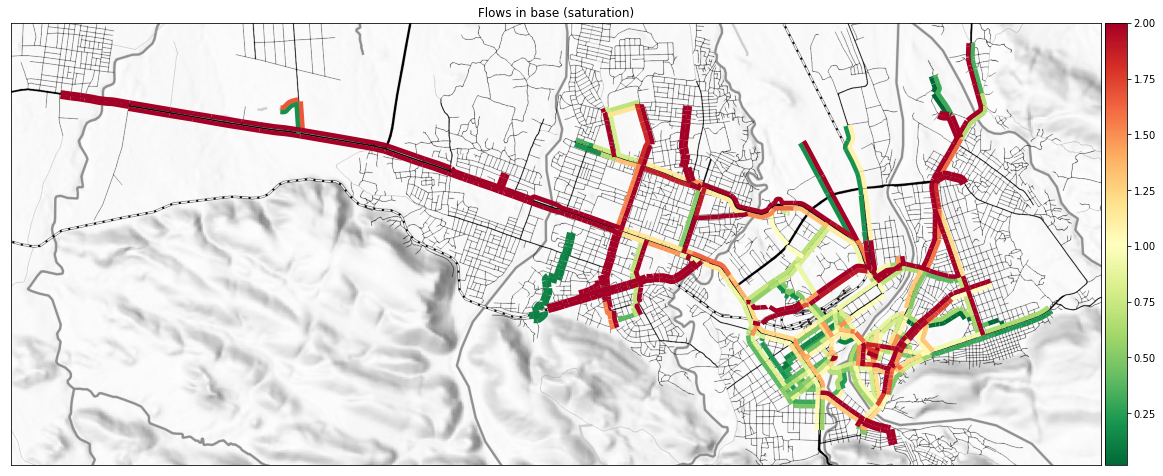

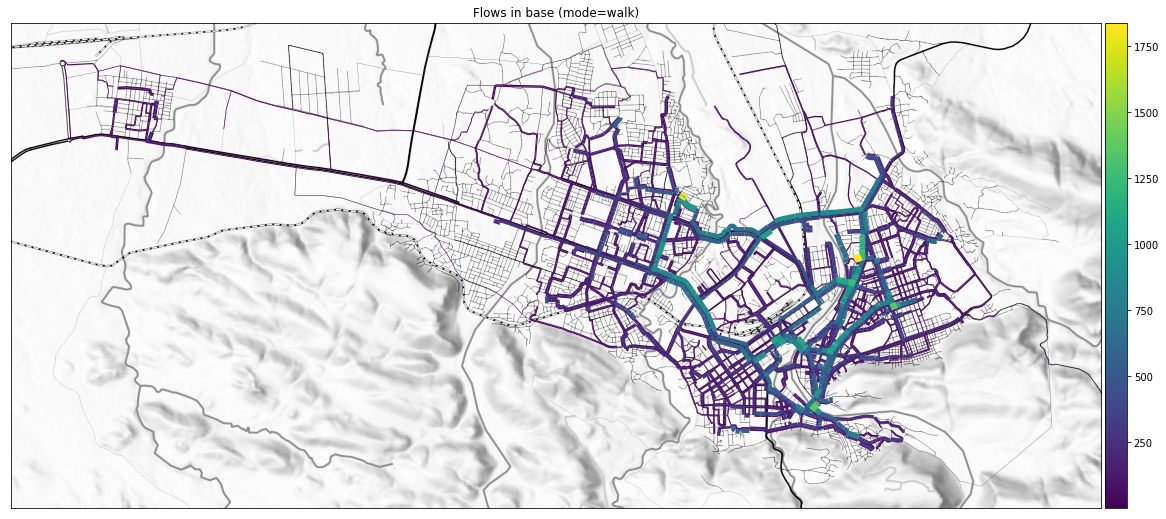

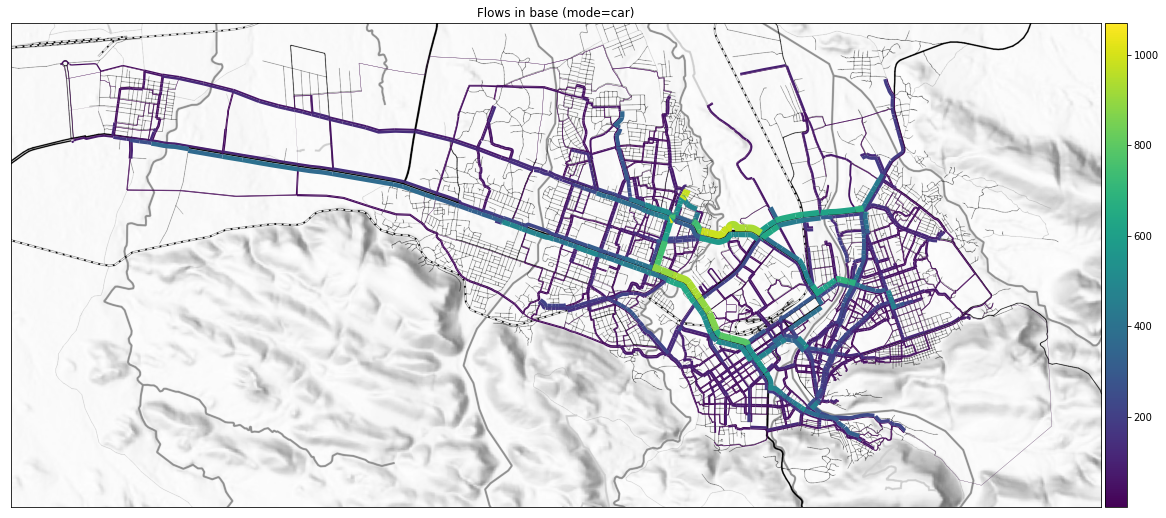

In [34]:
sm.road_links['pt_capacity'] = assign(sm.links['capacity'], sm.links['road_link_list'])
sm.road_links['saturation'] = np.clip(sm.road_links['pt'] / sm.road_links['pt_capacity'], 0, 2)

for column in ['pt_capacity', 'pt']:#, 'walk',  'car']:
    l = sm.road_links
    l = l.loc[l[column]>0]
    ax = bandwidth(
        l, column, figsize=(20,  10), legend=True, 
        cmap='viridis', max_linewidth_meters=100, power=0.5) #, vmax=15000)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    rasterio.plot.show(raster, ax=ax, adjust=None, cmap='Greys_r', with_bounds=True)
    if True:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_title('Flows in {scen} (mode={mode})'.format(mode=column, scen=scenario))
    fig = ax.get_figure()
    fig.savefig('../../outputs/assignment_{mode}_{scen}.png'.format(mode=column, scen=scenario), bbox_inches='tight')
    
for column in ['saturation']:
    l = sm.road_links
    l = l.loc[l[column]>0]
    ax = bandwidth(l, column, figsize=(20,  10), legend=True, cmap='RdYlGn_r', max_linewidth_meters=50, power=0)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    rasterio.plot.show(raster, ax=ax, adjust=None, cmap='Greys_r', with_bounds=True)
    if True:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_title('Flows in {scen} ({mode})'.format(mode=column, scen=scenario))
    fig = ax.get_figure()
    fig.savefig('../../outputs/assignment_{mode}_{scen}.png'.format(mode=column, scen=scenario), bbox_inches='tight')
    
for column in [ 'walk',  'car']:
    l = sm.road_links
    l = l.loc[l[column]>0]
    ax = bandwidth(
        l, column, figsize=(20,  10), legend=True, 
        cmap='viridis', max_linewidth_meters=100, power=0.5)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    rasterio.plot.show(raster, ax=ax, adjust=None, cmap='Greys_r', with_bounds=True)
    if True:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_title('Flows in {scen} (mode={mode})'.format(mode=column, scen=scenario))
    fig = ax.get_figure()
    fig.savefig('../../outputs/assignment_{mode}_{scen}.png'.format(mode=column, scen=scenario), bbox_inches='tight')

In [35]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined